In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import statsmodels.api as sm
from scipy.stats import norm
from scipy.stats import kurtosis
from scipy.stats import skew
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn import datasets

In [2]:
# 3. Učitati bazu u DataFrame. Proveriti kako izgleda prvih nekoliko vrsta u bazi.
shenyang = pd.read_csv("Shenyang.csv")
shenyang.head()

,No,year,month,day,hour,season,PM_Taiyuanjie,PM_US Post,PM_Xiaoheyan,DEWP,HUMI,PRES,TEMP,cbwd,Iws,precipitation,Iprec
0,1,2010,1,1,0,4,NaN,NaN,NaN,-26.0,69.79,1024.0,-22.0,NE,1.0289,NaN,NaN
1,2,2010,1,1,1,4,NaN,NaN,NaN,-26.0,76.26,1024.0,-23.0,NE,2.5722,NaN,NaN
2,3,2010,1,1,2,4,NaN,NaN,NaN,-27.0,69.56,1023.0,-23.0,NE,5.1444,NaN,NaN
3,4,2010,1,1,3,4,NaN,NaN,NaN,-27.0,69.56,1023.0,-23.0,NE,7.7166,NaN,NaN
4,5,2010,1,1,4,4,NaN,NaN,NaN,-27.0,69.56,1022.0,-23.0,NE,9.7744,NaN,NaN


In [3]:
# 4. Koliko ima obeležja? Koliko ima uzoraka? 
shenyang.shape

(52584, 17)

In [4]:
# 4. Šta predstavlja jedan uzorak baze?
shenyang.iloc[0]
# Predstavlja prikaz atmosferskih parametara za odredjeni sat, dan, mesec u odredjenoj godini

No                    1
year               2010
month                 1
day                   1
hour                  0
season                4
PM_Taiyuanjie       NaN
PM_US Post          NaN
PM_Xiaoheyan        NaN
DEWP              -26.0
HUMI              69.79
PRES             1024.0
TEMP              -22.0
cbwd                 NE
Iws              1.0289
precipitation       NaN
Iprec               NaN
Name: 0, dtype: object

In [5]:
# 4. Kojim obelezjima raspolazemo ?
shenyang.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52584 entries, 0 to 52583
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   No             52584 non-null  int64  
 1   year           52584 non-null  int64  
 2   month          52584 non-null  int64  
 3   day            52584 non-null  int64  
 4   hour           52584 non-null  int64  
 5   season         52584 non-null  int64  
 6   PM_Taiyuanjie  24388 non-null  float64
 7   PM_US Post     21680 non-null  float64
 8   PM_Xiaoheyan   24627 non-null  float64
 9   DEWP           51892 non-null  float64
 10  HUMI           51904 non-null  float64
 11  PRES           51892 non-null  float64
 12  TEMP           51892 non-null  float64
 13  cbwd           51892 non-null  object 
 14  Iws            51892 non-null  float64
 15  precipitation  39821 non-null  float64
 16  Iprec          39821 non-null  float64
dtypes: float64(10), int64(6), object(1)
memory usage: 

In [6]:
# 4. Koja obeležja su kategorička, a koja numerička? 
# Kategoricka:
# 	- year- moglo bi da bude kategoricko jer nema neogranicen broj godina koje se nalaze u skupu, vec samo 6
# 	- month- kategoricko, ali predstavljeno pomocu uredjene 12torke brojeva.
# 	- season - kategoricko, ali je takodje predstavljeno pomocu brojeva
# 	- cbwd - kategoricko je
# Numericka:
# 	- No
# 	- day:
# 	- hour:
# 	- PM: koncentracija PM2.5 čestica na nekoliko lokacija (ug/m3)
# 	- DEWP: temperatura rose/kondenzacije (stepeni Celzijusa)
# 	- TEMP: temperatura (stepeni Celzijusa)
# 	- HUMI: vlažnost vazduha (%)
# 	- PRES: vazdušni pritisak (hPa)
# 	- Iws: brzina vetra (m/s)
# 	- precipitation: padavine na sat (mm)
# 	- Iprec: ukupne padavine (mm)

In [7]:
# 4. Postoje li nedostajući podaci?
# Primecujemo odma da je 5 kolona ispunjeno sa dosta NaN vrednosti (PM_US Post,PM_Taiyuanjie,PM_Xiaoheyan,precipitation,Iprec)
total = shenyang.isnull().sum().sort_values(ascending=False)
percent = (shenyang.isnull().sum()/len(shenyang)).sort_values(ascending=False)
NaNs_percentage = pd.concat([total, percent], axis=1, keys=['Total', 'Percentage'])
NaNs_percentage
# NaNs_percentage = pd.DataFrame(total)
# NaNs_percentage['Percentage'] = percent
# NaNs_percentage.rename(columns = {0: 'Total'}, inplace = True) # preimenovanje kolone sa nazivom '0' u kolinu 'Total'
# NaNs_percentage

,Total,Percentage
PM_US Post,30904,0.587707
PM_Taiyuanjie,28196,0.536209
PM_Xiaoheyan,27957,0.531664
precipitation,12763,0.242716
Iprec,12763,0.242716
DEWP,692,0.013160
PRES,692,0.013160
TEMP,692,0.013160
cbwd,692,0.013160
Iws,692,0.013160


<BarContainer object of 5 artists>

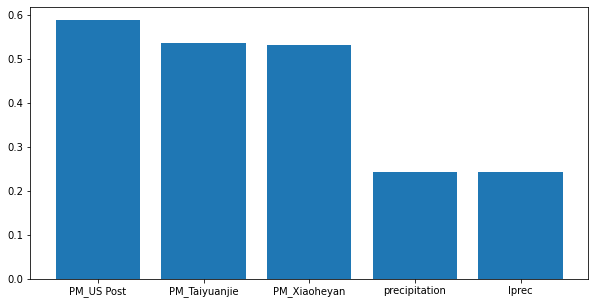

In [8]:
# 4. Postoje li nedostajući podaci?
# Prikazacemo prvih 5 vrednosti u bar grafiku, jer su one najkriticnije sto se tice nan vrednosti

plt.figure(figsize=(10,5))
NaNs_to_track = NaNs_percentage.iloc[0:5]
plt.bar(NaNs_to_track.index, NaNs_to_track['Percentage'])

In [9]:
# Posto je nedostatak podataka u kolonama 'DEWP', 'PRES', 'TEMP', 'cbwd', 'Iws', 'HUMI' oko 1%, uzorke koji imaju
# nan vrednosti u ovim kolonama mozemo obrisati
shenyang.dropna(subset=['DEWP', 'PRES', 'TEMP', 'cbwd', 'Iws', 'HUMI'], inplace = True)
shenyang.shape

(51892, 17)

In [10]:
# Posto kolona 'No' ima sve razlicite vrednosti - > od nje nemamo nekog znacaja. Ovu kolonu cemo obrisati
shenyang.drop('No', axis = 1, inplace = True)
print(shenyang.shape)
shenyang

(51892, 16)


,year,month,day,hour,season,PM_Taiyuanjie,PM_US Post,PM_Xiaoheyan,DEWP,HUMI,PRES,TEMP,cbwd,Iws,precipitation,Iprec
0,2010,1,1,0,4,NaN,NaN,NaN,-26.0,69.79,1024.0,-22.0,NE,1.0289,NaN,NaN
1,2010,1,1,1,4,NaN,NaN,NaN,-26.0,76.26,1024.0,-23.0,NE,2.5722,NaN,NaN
2,2010,1,1,2,4,NaN,NaN,NaN,-27.0,69.56,1023.0,-23.0,NE,5.1444,NaN,NaN
3,2010,1,1,3,4,NaN,NaN,NaN,-27.0,69.56,1023.0,-23.0,NE,7.7166,NaN,NaN
4,2010,1,1,4,4,NaN,NaN,NaN,-27.0,69.56,1022.0,-23.0,NE,9.7744,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52579,2015,12,31,19,4,162.0,166.0,435.0,-10.0,92.42,1031.0,-9.0,SE,2.0000,0.0,0.0
52580,2015,12,31,20,4,255.0,259.0,429.0,-10.0,79.10,1030.0,-7.0,SE,5.0000,0.0,0.0
52581,2015,12,31,21,4,266.0,368.0,361.0,-10.0,79.10,1030.0,-7.0,SE,8.0000,0.0,0.0
52582,2015,12,31,22,4,202.0,319.0,342.0,-10.0,79.10,1028.0,-7.0,SE,11.0000,NaN,NaN


In [11]:
# 5. Izbaciti obeležja koja se odnose na sve lokacije merenja koncentracije PM čestica osim US Post.
shenyang.drop('PM_Taiyuanjie', axis = 1, inplace= True)
shenyang.drop('PM_Xiaoheyan', axis = 1, inplace= True)
shenyang

,year,month,day,hour,season,PM_US Post,DEWP,HUMI,PRES,TEMP,cbwd,Iws,precipitation,Iprec
0,2010,1,1,0,4,NaN,-26.0,69.79,1024.0,-22.0,NE,1.0289,NaN,NaN
1,2010,1,1,1,4,NaN,-26.0,76.26,1024.0,-23.0,NE,2.5722,NaN,NaN
2,2010,1,1,2,4,NaN,-27.0,69.56,1023.0,-23.0,NE,5.1444,NaN,NaN
3,2010,1,1,3,4,NaN,-27.0,69.56,1023.0,-23.0,NE,7.7166,NaN,NaN
4,2010,1,1,4,4,NaN,-27.0,69.56,1022.0,-23.0,NE,9.7744,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52579,2015,12,31,19,4,166.0,-10.0,92.42,1031.0,-9.0,SE,2.0000,0.0,0.0
52580,2015,12,31,20,4,259.0,-10.0,79.10,1030.0,-7.0,SE,5.0000,0.0,0.0
52581,2015,12,31,21,4,368.0,-10.0,79.10,1030.0,-7.0,SE,8.0000,0.0,0.0
52582,2015,12,31,22,4,319.0,-10.0,79.10,1028.0,-7.0,SE,11.0000,NaN,NaN


In [12]:
# 4. Postoje li nelogične/nevalidne vrednosti?
shenyang.describe()

,year,month,day,hour,season,PM_US Post,DEWP,HUMI,PRES,TEMP,Iws,precipitation,Iprec
count,51892.000000,51892.000000,51892.000000,51892.000000,51892.000000,21679.000000,51892.000000,51892.000000,51892.000000,51892.000000,51892.000000,39597.000000,39597.000000
mean,2012.530448,6.532124,15.720612,11.500944,2.495414,75.836662,0.850304,62.998006,1016.005492,8.460495,19.816487,0.083610,0.495765
std,1.696970,3.457407,8.798960,6.919955,1.117277,68.997412,14.261483,21.878652,9.724308,13.948303,32.135270,0.718312,4.363589
min,2010.000000,1.000000,1.000000,0.000000,1.000000,1.000000,-97.000000,0.000000,988.000000,-28.000000,0.000000,0.000000,0.000000
25%,2011.000000,4.000000,8.000000,5.000000,1.000000,31.000000,-11.000000,46.220000,1008.000000,-3.000000,3.000000,0.000000,0.000000
50%,2013.000000,7.000000,16.000000,12.000000,2.000000,57.000000,1.000000,64.720000,1016.000000,10.000000,8.000000,0.000000,0.000000
75%,2014.000000,10.000000,23.000000,17.000000,3.000000,97.000000,14.000000,82.010000,1024.000000,21.000000,23.000000,0.000000,0.000000
max,2015.000000,12.000000,31.000000,23.000000,4.000000,932.000000,28.000000,100.000000,1043.000000,35.000000,465.000000,33.100000,120.000000


In [13]:
# 4. Postoje li nelogične/nevalidne vrednosti?

#-----------------------------DEWP column------------------------------------
# U koloni DEWP, nelogicna vrednost jeste temperatura od -97 stepeni celzijusa.
# Najverovatnije je u pitanju greska prilikom unosa, jer ova temperatura jos uvek 
# nije nigde zabelezena. Dodatno, pojavljuje se samo u jednom uzorku,tako da taj 
# uzorak mozemo otkloniti, jer nije od velike vaznosti
shenyang.drop(shenyang[shenyang['DEWP'] == -97].index, axis = 0, inplace = True)
print(shenyang['DEWP'].unique())
print(shenyang.shape)

[-26. -27. -25. -24. -23. -22. -20. -18. -17. -16. -15. -19. -29. -28.
 -30. -31. -21. -14. -13. -12. -11. -10.  -9.  -7.  -8.  -6.  -5.  -4.
  -3.  -2.  -1.   0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  11.
  10.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.
  25.  26. -32.  27.  28.]
(51891, 14)


In [14]:
# 4. Postoje li nelogične/nevalidne vrednosti?

#-----------------------------Iws column------------------------------------
# Po Fujitsa skali, brzina vetra koja prelazi 322 km/h (89.44444444444444 m/s) 
# ima frekvenciju dogadjanja od 0.05%, tako da sve vrednosti u koloni 'Iws' koje su preko ove vrednosti
# imaju veliku verovatnocu da nisu ispravno unete, a pogotovo one koje su mnogo vece od 89.44444444444444 m/s
# jer je najrazorniji tornado koji je zabelezen imao brzinu vetra od ~116m/s. I zove se "Daulatpur–Saturia"
invalid_values = shenyang[shenyang['Iws'] > 89.44444444444444]
invalid_values_percentage = len(invalid_values)/ len(shenyang) 
invalid_values_percentage*100 # ovde vidimo da je preveliki procenat slucajeva sa velikom brzinom vetra

3.7135534100325684

In [15]:
# iz tog razloga, vrednosti koje su preko 89.44444444444444 mozemo postaviti na NaN, kako bi ih mogli zameniti sa
# srednjom vrednoscu; uzeti prethodne vrednosti i staviti na njihovo mesto itd...
shenyang.at[shenyang[shenyang['Iws'] > 89.44444444444444].index, 'Iws'] = np.nan

# Najlogicnije je da na nedostajuce vrednosti kolone 'Iws' ubacimo sred. vred sata pre i sata posle trenutne vrednosti
# interpolate
shenyang['Iws'].interpolate(inplace = True)
shenyang['Iws'].isna().sum() / len(shenyang['Iws'])

0.0

In [16]:
# Vrednosti iz kolone cbwd koja je po prirodi kategoricka, mozemo pretvoriti u numericke,
# jer nije dobro imati kategoricke vrednosti tokom rada sa linearnom regresijom
cv_values = shenyang[shenyang['cbwd'] == 'cv']
shenyang.at[cv_values.index, 'cbwd'] = 0

ne_values = shenyang[shenyang['cbwd'] == 'NE']
shenyang.at[ne_values.index, 'cbwd'] = 1

nw_values = shenyang[shenyang['cbwd'] == 'NW']
shenyang.at[nw_values.index, 'cbwd'] = 2

se_values = shenyang[shenyang['cbwd'] == 'SE']
shenyang.at[se_values.index, 'cbwd'] = 3

sw_values = shenyang[shenyang['cbwd'] == 'SW']
shenyang.at[sw_values.index, 'cbwd'] = 4

shenyang['cbwd'].unique()

array([1, 0, 3, 2, 4], dtype=object)

In [17]:
# 4. Postoje li nelogične/nevalidne vrednosti?

#-----------------------------precipitation column------------------------------------

# Mozemo primetiti ogroman procenat vrednosti 0 u ovoj koloni. 
# To je razlog zbog cega su nule na min, 25%, 50% i 75% (0 je i na 75% zbog onih 0.242716*100& NaN vrednosti koje imamo)
precipitation_zeros_percentage = len(shenyang[shenyang['precipitation'] == 0]) / len(shenyang)
precipitation_zeros_percentage

0.7177352527413231

In [18]:
# ovde racunamo procenat vrednosti koje su razlicite od 0 i nan
precipitation_real_values = 1 - (NaNs_percentage.loc['precipitation', 'Percentage'] + precipitation_zeros_percentage)
print(precipitation_real_values*100) # samo oko 3.95% vrednosti je razlicito od 0 i NaN
print(shenyang['precipitation'].unique()) # te vrednosti mozemo videti ovde

3.954833161893856
[ nan  0.   0.5  0.8  1.1  0.1  0.6  1.4  2.7  1.9  1.5  0.2  0.4  1.3
  0.3  2.1  1.7  0.7  2.6  2.   3.   3.1  2.5  2.3  0.9  2.9  2.4  1.6
  1.2  5.9  5.6  7.2  3.4  1.   3.8  9.4  5.5  8.8  4.   1.8  4.9  3.9
  5.8  2.8 11.1 17.  12.1 20.8 11.5 14.7  5.   4.2 10.   9.8  5.1 21.1
 15.6 11.2  4.5 13.2  3.3  6.6  4.7  6.   7.6  6.3 33.1  5.7  3.5  2.2
  5.2  3.2  4.3  6.4  3.7  6.8  6.5  3.6 12.   6.2  4.1  7.1  9.6  6.1
  6.7 18.3  7.4  4.6  8.7 19.9  5.4  4.4 13.1  9.2 18.1 14.2 16.2 11.9
  6.9  7.7  7.  10.1 14.3  7.5 13.7 20.7 13.5 10.8  8.4 23.3 20.3 17.1
  9.7 10.5 13.3  4.8 21.9 13.9 23.9 16.3  9.3 15.3  7.3  8.3]


In [19]:
# Posto 0 predstavlja: nema padavina po satu, NaN: nepoznata vrednost, a ostale vrednosti neku kolicinu padavina po satu.
# Mozda bismo mogli od ovog obeleznja da napravimo kategoricko obelezje gde bismo uveli sledece kategorije:
# 0 - nema padavina                        (0)
# 0.01 - 5 mm - mala kolicina padavina     (1)
# 5.1 - 10 mm - srednja kolicina padavina  (2)
# 10.1 - 15 mm - velika kolicina padavina  (3)
# 15.1 > - ogromna kolicina padavina       (4)

# upisacemo srednju vrednost padavina po satu u mesece koji su izmedju oktobra i marta, jer je tada povecana 
# verovatnoca bilo kakvih padavina, dok cemo u ostale mesece staviti 0 padavina
precipitation_months= shenyang[(shenyang['month'] >= 1) & (shenyang['month'] <= 3) | 
                               (shenyang['month'] >= 10) & (shenyang['month'] <= 12)]

shenyang.at[precipitation_months.index, 'precipitation'] = shenyang['precipitation'].mean() # 'at' funkcija koja na 
# tacno zadatoj lokaciji upisuje datu vrednost
shenyang['precipitation'].fillna(0, inplace = True)
shenyang

,year,month,day,hour,season,PM_US Post,DEWP,HUMI,PRES,TEMP,cbwd,Iws,precipitation,Iprec
0,2010,1,1,0,4,NaN,-26.0,69.79,1024.0,-22.0,1,1.0289,0.08361,NaN
1,2010,1,1,1,4,NaN,-26.0,76.26,1024.0,-23.0,1,2.5722,0.08361,NaN
2,2010,1,1,2,4,NaN,-27.0,69.56,1023.0,-23.0,1,5.1444,0.08361,NaN
3,2010,1,1,3,4,NaN,-27.0,69.56,1023.0,-23.0,1,7.7166,0.08361,NaN
4,2010,1,1,4,4,NaN,-27.0,69.56,1022.0,-23.0,1,9.7744,0.08361,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52579,2015,12,31,19,4,166.0,-10.0,92.42,1031.0,-9.0,3,2.0000,0.08361,0.0
52580,2015,12,31,20,4,259.0,-10.0,79.10,1030.0,-7.0,3,5.0000,0.08361,0.0
52581,2015,12,31,21,4,368.0,-10.0,79.10,1030.0,-7.0,3,8.0000,0.08361,0.0
52582,2015,12,31,22,4,319.0,-10.0,79.10,1028.0,-7.0,3,11.0000,0.08361,NaN


In [20]:
# Ovde unosimo kategoricke vrednosti padavina po satu (0-4) kao sto smo rekli
for_one_values = shenyang[(shenyang['precipitation'] >= 0.01) & (shenyang['precipitation'] <= 5)]
shenyang.at[for_one_values.index, 'precipitation'] = 1
for_two_values = shenyang[(shenyang['precipitation'] >= 5.1) & (shenyang['precipitation'] <= 10)]
shenyang.at[for_two_values.index, 'precipitation'] = 2
for_three_values = shenyang[(shenyang['precipitation'] >= 10.1) & (shenyang['precipitation'] <= 15)]
shenyang.at[for_three_values.index, 'precipitation'] = 3
for_four_values = shenyang[shenyang['precipitation'] > 15]
shenyang.at[for_four_values.index, 'precipitation'] = 4
shenyang['precipitation'].unique() # vidimo da su u koloni precipitation samo vrednosti 0-4

array([1., 0., 2., 3., 4.])

In [21]:
# Posto su nam uzorci takvi da pokazuju podatke u odredjenom satu u toku dana, nema smisla da drzimo u uzorku
# i podatak o ukupnoj kolicini padavina, tako da cemo ovu kolonu otkloniti
shenyang.drop('Iprec', axis = 1, inplace = True)
shenyang

,year,month,day,hour,season,PM_US Post,DEWP,HUMI,PRES,TEMP,cbwd,Iws,precipitation
0,2010,1,1,0,4,NaN,-26.0,69.79,1024.0,-22.0,1,1.0289,1.0
1,2010,1,1,1,4,NaN,-26.0,76.26,1024.0,-23.0,1,2.5722,1.0
2,2010,1,1,2,4,NaN,-27.0,69.56,1023.0,-23.0,1,5.1444,1.0
3,2010,1,1,3,4,NaN,-27.0,69.56,1023.0,-23.0,1,7.7166,1.0
4,2010,1,1,4,4,NaN,-27.0,69.56,1022.0,-23.0,1,9.7744,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
52579,2015,12,31,19,4,166.0,-10.0,92.42,1031.0,-9.0,3,2.0000,1.0
52580,2015,12,31,20,4,259.0,-10.0,79.10,1030.0,-7.0,3,5.0000,1.0
52581,2015,12,31,21,4,368.0,-10.0,79.10,1030.0,-7.0,3,8.0000,1.0
52582,2015,12,31,22,4,319.0,-10.0,79.10,1028.0,-7.0,3,11.0000,1.0


In [22]:
# --------------------------------------------------------------------------------------------------------------------------
# Sada cemo izracunati koliko NaN vrednosti ima u koloni 'PM_US Post' po godinama, mozda i uocimo nesto zanimljivo
# Dolazimo do zakljucka da kompletna 2010 godina ima samo NaN vrednosti u koloni 'PM_US Post'
year_2010 = shenyang[shenyang['year'] == 2010] # ovde uzimamo ukupan broj uzoraka koji je iz 2010 godine
year_2010_NaNs = year_2010['PM_US Post'].isna().sum() / len(year_2010) # dobijamo procenat NaN vrednosti u koloni
# year_2010_NaNs
# Dolazimo do zakljucka da kompletna 2011 godina ima samo NaN vrednosti u koloni 'PM_US Post'
year_2011 = shenyang[shenyang['year'] == 2011] # ovde uzimamo ukupan broj uzoraka koji je iz 2011 godine
year_2011_NaNs = year_2011['PM_US Post'].isna().sum() / len(year_2011) # dobijamo procenat NaN vrednosti u koloni
# year_2011_NaNs
# Dolazimo do zakljucka da kompletna 2012 godina ima samo NaN vrednosti u koloni 'PM_US Post'
year_2012 = shenyang[shenyang['year'] == 2012] # ovde uzimamo ukupan broj uzoraka koji je iz 2012 godine
year_2012_NaNs = year_2012['PM_US Post'].isna().sum() / len(year_2012) # dobijamo procenat NaN vrednosti u koloni
# year_2012_NaNs
# Dolazimo do zakljucka da 2013 godina ima 0.38573059360730594*100% NaN vrednosti u koloni 'PM_US Post'
year_2013 = shenyang[shenyang['year'] == 2013] # ovde uzimamo ukupan broj uzoraka koji je iz 2013 godine
year_2013_NaNs = year_2013['PM_US Post'].isna().sum() / len(year_2013) # dobijamo procenat NaN vrednosti u koloni
# year_2013_NaNs
# Dolazimo do zakljucka da 2014 godina ima 0.04189497716894977*100% NaN vrednosti u koloni 'PM_US Post'
year_2014 = shenyang[shenyang['year'] == 2014] # ovde uzimamo ukupan broj uzoraka koji je iz 2014 godine
year_2014_NaNs = year_2014['PM_US Post'].isna().sum() / len(year_2014) # dobijamo procenat NaN vrednosti u koloni
# year_2014_NaNs
# Dolazimo do zakljucka da 2015 godina ima 0.09748858447488584*100% NaN vrednosti u koloni 'PM_US Post'
year_2015 = shenyang[shenyang['year'] == 2015] # ovde uzimamo ukupan broj uzoraka koji je iz 2015 godine
year_2015_NaNs = year_2015['PM_US Post'].isna().sum() / len(year_2015) # dobijamo procenat NaN vrednosti u koloni
year_2015_NaNs

0.09748858447488584

In [23]:
# Prvo cemo uraditi ffill na podatke iz 2014 i 2015 godine
indexes_to_fill_2014 = shenyang[shenyang['year'] == 2014].index
shenyang.loc[min(indexes_to_fill_2014) : max(indexes_to_fill_2014), 'PM_US Post'].fillna(method = 'ffill', inplace = True)
shenyang[shenyang['year'] == 2014]['PM_US Post'].isna().sum()

indexes_to_fill_2015 = shenyang[shenyang['year'] == 2015].index
shenyang.loc[min(indexes_to_fill_2015) : max(indexes_to_fill_2015), 'PM_US Post'].fillna(method = 'ffill', inplace = True)
shenyang[shenyang['year'] == 2015]['PM_US Post'].isnull().sum()

0

In [24]:
# S obzirom da nemamo bas nijednu poznatu vrednost za kolonu 'PM_US Post' u godinama 2010, 2011 i 2012,
# obrisacemo uzorke koji pripadaju ovim godinama
years_to_drop = shenyang[(shenyang['year'] == 2010) | (shenyang['year'] == 2011) | (shenyang['year'] == 2012)]
shenyang.drop(years_to_drop.index, inplace = True)
shenyang.shape


(26276, 13)

In [25]:
# provericemo koliko svaki mesec ima nedostajucih vrednosti u 2013 godini.
# i svaki mesec koji ima preko 10% nedostajucih podataka cemo obrisati

months_array = list(range(1, 13))
months_to_drop = []
for month in months_array:
    nan = len(year_2013[(year_2013['month'] == month) & (year_2013['PM_US Post'].isna())])
    full = len(year_2013[year_2013['month'] == month])
    if nan/full > 0.1:
        months_to_drop.append(month)
    
# sada cemo obrisati iz dataframe-a sve mesece u 2013 koje su u listi ' months_to_drop'
months_to_drop_indexes = year_2013[year_2013['month'].isin(months_to_drop)].index
shenyang.drop(months_to_drop_indexes, axis = 0, inplace = True)
months_to_drop

[1, 2, 3, 4, 7, 8]

In [26]:
# i treba popuniti one nepoznate vrednosti u PM_US Post koje su ostale, jer ima meseci koje su prosle uslov od 10%,
# ali su i oni imali nepoznate vredosti, samo ne preko 10%. Te vrednosti cemo popuniti interpolate() metodom
shenyang.interpolate(inplace = True)

In [27]:
# ponovo proveravamo da li u skupu imamo neke nan vrednosti
total = shenyang.isnull().sum().sort_values(ascending=False)
percent = (shenyang.isnull().sum()/len(shenyang)).sort_values(ascending=False)
NaNs_percentage = pd.concat([total, percent], axis=1, keys=['Total', 'Percentage'])
NaNs_percentage

,Total,Percentage
year,0,0.0
month,0,0.0
day,0,0.0
hour,0,0.0
season,0,0.0
PM_US Post,0,0.0
DEWP,0,0.0
HUMI,0,0.0
PRES,0,0.0
TEMP,0,0.0


In [28]:
# radi lakseg rada sa boxplot-om postavljamo godine za index
shenyang_years= shenyang.set_index('year')
shenyang_years.head()
shenyang_months= shenyang.set_index('month')
shenyang_months.head()

,year,day,hour,season,PM_US Post,DEWP,HUMI,PRES,TEMP,cbwd,Iws,precipitation
month,,,,,,,,,,,,
5,2013,1,0,1,69.0,7.0,87.28,1014.0,9.0,2,38.0,0.0
5,2013,1,1,1,69.0,7.0,93.40,1014.0,8.0,2,40.0,0.0
5,2013,1,2,1,64.0,6.0,93.35,1014.0,7.0,0,0.0,0.0
5,2013,1,3,1,63.0,5.0,93.29,1014.0,6.0,4,1.0,0.0
5,2013,1,4,1,63.0,5.0,93.29,1014.0,6.0,0,1.0,0.0


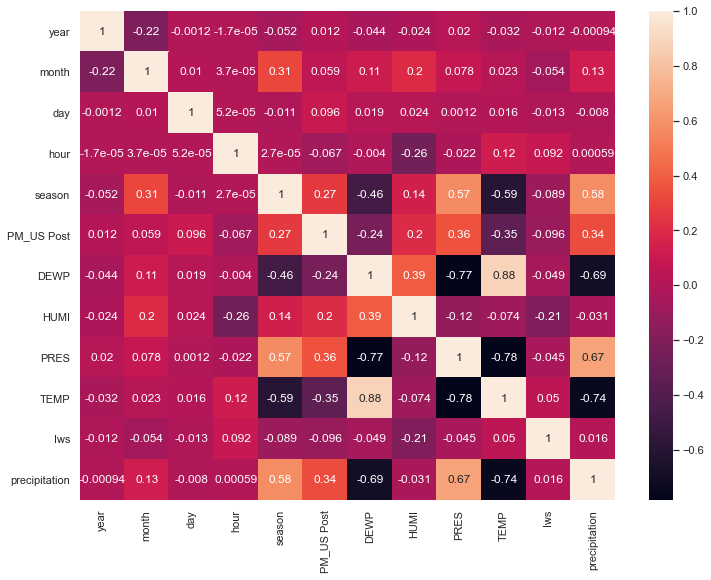

In [75]:
# prikaz korelacije izmedju obelezja
corr = shenyang.corr()
f = plt.figure(figsize=(12, 9))
sb.heatmap(corr, annot=True);

In [30]:
# Sto se tice korelacije izmedju obelezja, prvo mozemo primetiti, da su TEMP i DEWP u jakoj pozitivnoj korelaciji
# sto se i moglo ocekivati jer sto je veca temperatura, to je veca i kondenzacija, i suprotno. 
# Dalje mozemo primetiti da je season u pozitivnoj korelaciji sa precipitation, sto i ima smisla
# jer kada su zimski i jesenji periodi, padavine su cesce. 
# Vidimo takodje da su PRES i season u korelaciji. Dalje, vazdusni pritisak u korelaciji sa padavinama po satu...
# Sa druge strane, precipitation i TEMP su u negativnoj korelaciji jer sto su padavine vece, temperatura ce biti manja;
# Odatle sledi da ce precipitation biti u negativnoj korelaciji i sa DEWP
# Takodje TEMP i PRES

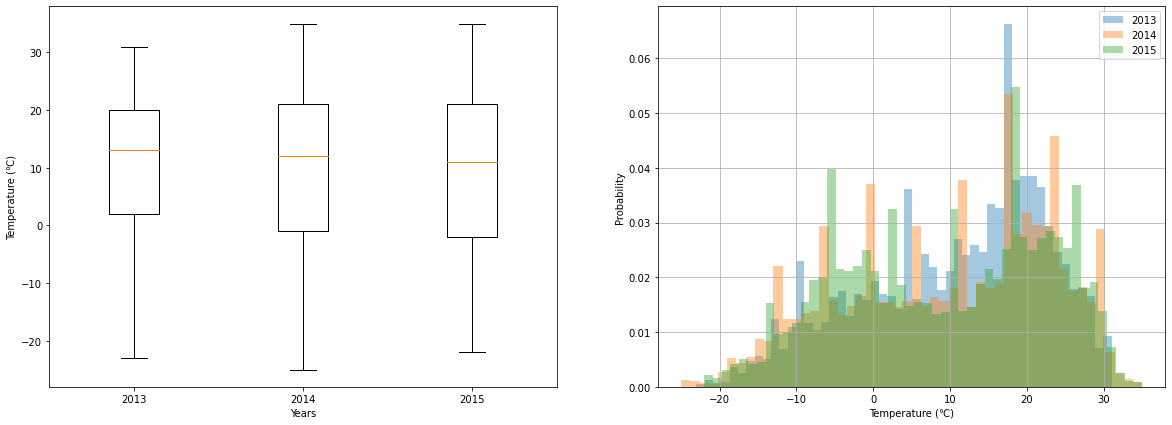

In [31]:
# TEMP kroz godine - boxplot
plt.figure(figsize=(20, 7))
plt.subplot(1, 2, 1)
plt.boxplot([shenyang_years.loc['2013','TEMP'],
             shenyang_years.loc['2014','TEMP'], 
             shenyang_years.loc['2015','TEMP']]) 

plt.ylabel('Temperature (℃)')
plt.xlabel('Years')
plt.xticks([1, 2, 3], ["2013", "2014", "2015"])
plt.subplot(1, 2, 2)
# Zastupljene temperature po godinama- histogram
plt.hist(shenyang_years.loc['2013','TEMP'], density=True, alpha=0.4, bins=50, label = '2013')
plt.hist(shenyang_years.loc['2014','TEMP'], density=True, alpha=0.4, bins=50, label = '2014')
plt.hist(shenyang_years.loc['2015','TEMP'], density=True, alpha=0.4, bins=50, label = '2015')

plt.ylabel('Probability')
plt.xlabel('Temperature (℃)')
plt.legend()
plt.grid()

Text(0.5, 0, 'Seasons')

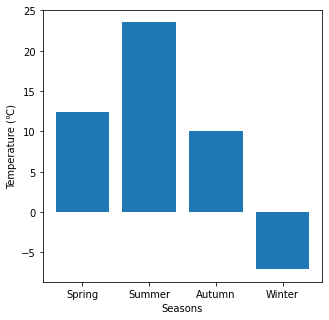

In [32]:
# Prosecne TEMP po sezonama
by_season = shenyang.groupby(by=['season']).mean()
seasons= ['Spring', 'Summer', 'Autumn', 'Winter']

plt.figure(figsize=(5,5))
seasons_temperature = by_season.iloc[0:5]
plt.bar(seasons, seasons_temperature['TEMP'])
plt.ylabel('Temperature (℃)')
plt.xlabel('Seasons')

Text(0, 0.5, 'hPa')

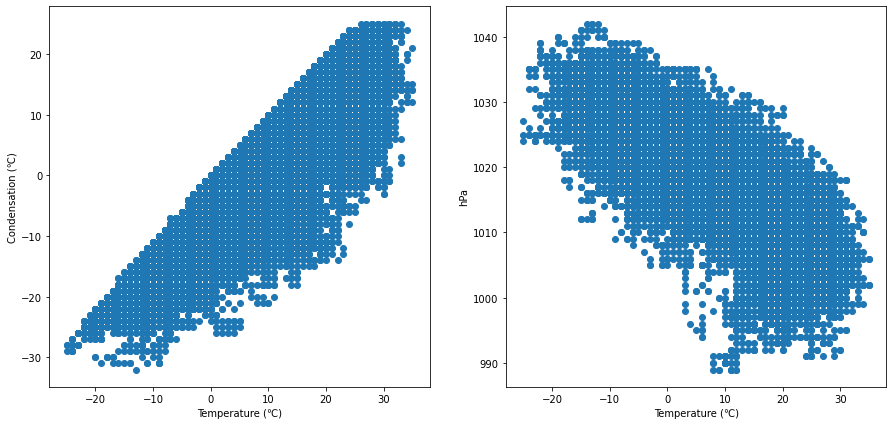

In [33]:
# za TEMP i DEWP mozemo uzeti jos jedan plot, koji pokazuje da su oni u pozitivnoj jakoj korelaciji
# temperatura visoka -> visoka je i kondenzacija
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
plt.scatter(shenyang_years['TEMP'],shenyang_years['DEWP'])
plt.xlabel('Temperature (℃)')
plt.ylabel('Condensation (℃)')
plt.subplot(1,2,2)
# dok su TEMP i PRES u negativnoj jakoj korelaciji, sto pokazuje da kada je temperatura visoka, vazdusni pritisak je nizak
plt.scatter(shenyang_years['TEMP'],shenyang_years['PRES'])
plt.xlabel('Temperature (℃)')
plt.ylabel('hPa')

Text(0, 0.5, 'Temperature (℃)')

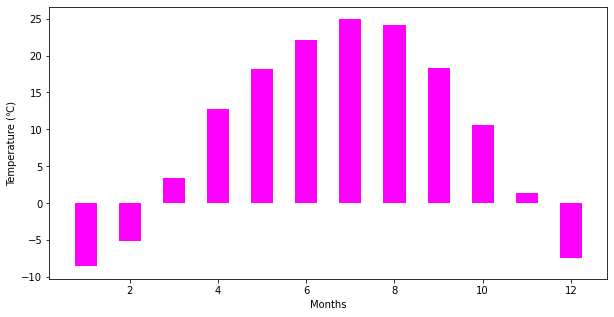

In [34]:
# veza izmedju meseca i temperature u njemu
month_gb = shenyang.groupby('month').mean()
plt.figure(figsize = (10, 5))
plt.bar(month_gb.index, month_gb['TEMP'], color = 'magenta',width = 0.5, label='2014')
plt.xlabel('Months')
plt.ylabel('Temperature (℃)')

D:\Anaconda\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\Anaconda\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\Anaconda\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings

Text(0, 0.5, 'Probability')

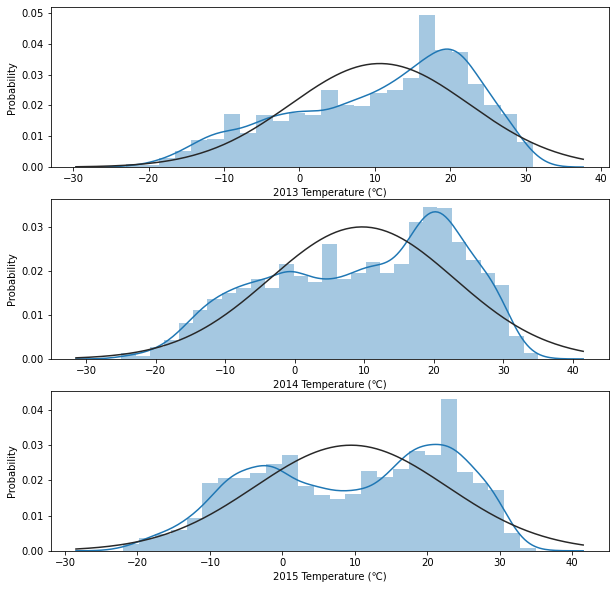

In [35]:
plt.figure(figsize = (10, 10))
plt.subplot(3,1,1)
temp_2013 = shenyang_years.loc['2013','TEMP']
sb.distplot(temp_2013, fit=norm)
plt.xlabel('2013 Temperature (℃)')
plt.ylabel('Probability')
plt.subplot(3,1,2)
temp_2014 = shenyang_years.loc['2014','TEMP']
sb.distplot(temp_2014, fit=norm)
plt.xlabel('2014 Temperature (℃)')
plt.ylabel('Probability')
plt.subplot(3,1,3)
temp_2015 = shenyang_years.loc['2015','TEMP']
sb.distplot(temp_2015, fit=norm)
plt.xlabel('2015 Temperature (℃)')
plt.ylabel('Probability')

In [36]:
print('koef.asimetrije za 2013:  %.2f' % skew(shenyang_years.loc['2013','TEMP']))
print('koef.spljoštenosti za 2013:  %.2f' % kurtosis(shenyang_years.loc['2013','TEMP']))

print('koef.asimetrije za 2014:  %.2f' % skew(shenyang_years.loc['2014','TEMP']))
print('koef.spljoštenosti za 2014:  %.2f' % kurtosis(shenyang_years.loc['2014','TEMP']))

print('koef.asimetrije za 2015:  %.2f' % skew(shenyang_years.loc['2015','TEMP']))
print('koef.spljoštenosti za 2015:  %.2f' % kurtosis(shenyang_years.loc['2015','TEMP']))

koef.asimetrije za 2013:  -0.52
koef.spljoštenosti za 2013:  -0.68
koef.asimetrije za 2014:  -0.34
koef.spljoštenosti za 2014:  -0.97
koef.asimetrije za 2015:  -0.21
koef.spljoštenosti za 2015:  -1.12


Text(0.5, 0, 'Wind directions')

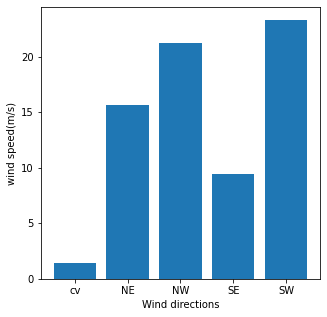

In [37]:
# Mozemo videti da postoji veza izmedju pravca vetra i njegove brzine
winds= shenyang.groupby('cbwd').mean()
para = ['cv', 'NE', 'NW', 'SE', 'SW']
cbwds= winds.index
plt.figure(figsize=(5,5))
plt.bar(para, winds['Iws'])
plt.ylabel('wind speed(m/s)')
plt.xlabel('Wind directions')

In [38]:
# na crosstab grafiku mozemo videti koji vetrovi su najzastupljeniji za koju sezonu
pd.crosstab(shenyang['season'],shenyang['cbwd']).style.background_gradient(cmap='summer_r')

cbwd,0,1,2,3,4
season,,,,,
1,262,710,835,952,2401
2,466,526,460,1542,2142
3,525,987,1480,1689,1870
4,417,1059,1082,1235,1271


Text(0.5, 0, 'Precipitation categories')

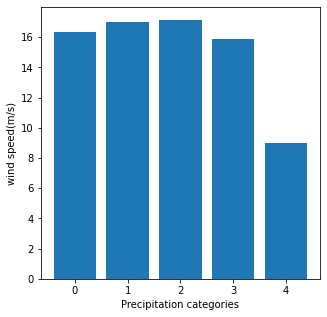

In [39]:
# primecujemo da kada ima bas mnogo padavina na sat, brzina vetra se drasticno smanjuje
precipitation_per_hour= shenyang.groupby('precipitation').mean()
preci= ['0', '1', '2', '3', '4']

plt.figure(figsize=(5,5))
plt.bar(preci, precipitation_per_hour['Iws'])
plt.ylabel('wind speed(m/s)')
plt.xlabel('Precipitation categories')

In [40]:
# pre analize PM_US Post kolone (ovde) se nastavljaju analize ostalih obelezja

count    21911.000000
mean        76.310506
std         69.301915
min          1.000000
25%         33.000000
50%         56.000000
75%         97.000000
max        932.000000
Name: PM_US Post, dtype: float64

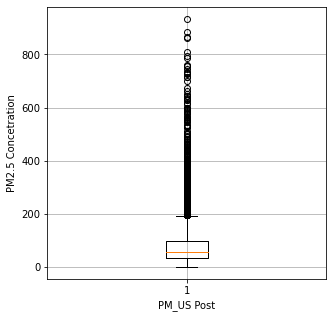

In [41]:
plt.figure(figsize=(5, 5))
plt.boxplot(shenyang_years['PM_US Post']) 

plt.ylabel('PM2.5 Concetration')
plt.xlabel('PM_US Post')
plt.grid()
shenyang_years['PM_US Post'].describe()

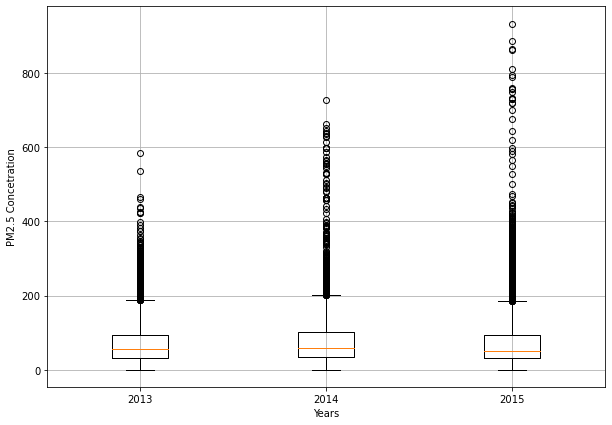

In [42]:
plt.figure(figsize=(10, 7))
plt.boxplot([shenyang_years.loc['2013','PM_US Post'],
             shenyang_years.loc['2014','PM_US Post'], 
             shenyang_years.loc['2015','PM_US Post']]) 

plt.ylabel('PM2.5 Concetration')
plt.xlabel('Years')
plt.xticks([1, 2, 3], ["2013", "2014", "2015"])
plt.grid()
# shenyang_years.loc['2013', 'PM_US Post'].describe()
# shenyang_years.loc['2014', 'PM_US Post'].describe()
# shenyang_years.loc['2015', 'PM_US Post'].describe()

In [43]:
post_gb = shenyang.groupby(by=['year', 'month']).mean()
post_gb.head()

day  hour  season  PM_US Post       DEWP       HUMI         PRES  \
year month                                                                      
2013 5      16.0  11.5     1.0   63.046371   7.751344  53.005390  1008.201613   
     6      15.5  11.5     2.0   43.487500  14.768056  65.803056  1006.504167   
     9      15.5  11.5     3.0   52.817361  11.583333  69.533236  1014.765278   
     10     16.0  11.5     3.0   86.316532   3.844086  69.098401  1021.114247   
     11     15.5  11.5     3.0   73.512500  -4.747222  62.874514  1019.551389   

                 TEMP        Iws  precipitation  
year month                                       
2013 5      18.993280  24.339382       0.021505  
     6      22.420833  16.319444       0.072222  
     9      18.129167  14.088194       0.070833  
     10     10.090054  13.201613       1.000000  
     11      2.129167  21.469444       1.000000

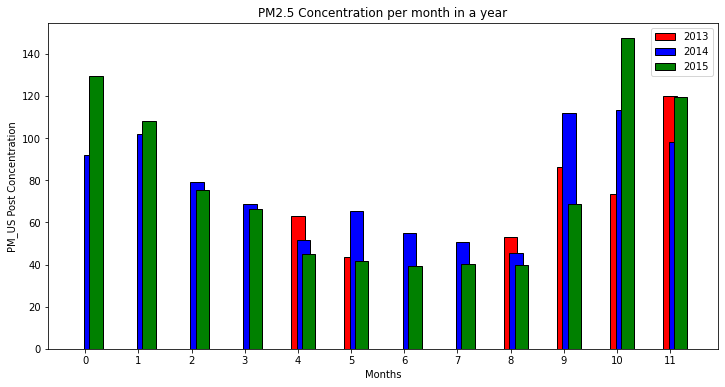

In [44]:
# u ovom grafiku mozemo videti koncentraciju pm2.5 po mesecima u godini, 
# u vezi 2013e godine, tamo gde nema crvenog bara znaci da za taj mesec 
# smo obrisali podatke i oni nisu dostupni
ma = ['Januar', 'Februar', 'Mart', 'April', 'Maj', 'Jun',
     'Jul', 'Avgust', 'Septembar', 'Oktobar', 'Novembar', 'Decembar']
PM_USPost2013_values = [0, 0, 0, 0, 
                        63.046371, 43.487500, 0, 0, 
                        52.817361, 86.316532, 73.512500, 119.987903]
PM_USPost2014_values= post_gb.iloc[6:18]['PM_US Post'].to_numpy();
PM_USPost2015_values= post_gb.iloc[18:30]['PM_US Post'].to_numpy();

n=12
r = np.arange(n)
width = 0.25
plt.figure(figsize=(12,6))
plt.bar(r, PM_USPost2013_values, color = 'red',width = width, edgecolor = 'black', label='2013')
plt.bar(r + 0.1, PM_USPost2014_values, color = 'blue',width = width, edgecolor = 'black',label='2014')
plt.bar(r + 0.2, PM_USPost2015_values, color = 'green',width = width, edgecolor = 'black', label='2015')
  
plt.xlabel("Months")
plt.ylabel("PM_US Post Concentration")
plt.title("PM2.5 Concentration per month in a year")
plt.xticks(r)
plt.legend()
plt.show()

count    5064.000000
mean      109.938981
std        83.119214
min         7.000000
25%        47.000000
50%        86.000000
75%       154.000000
max       932.000000
Name: PM_US Post, dtype: float64

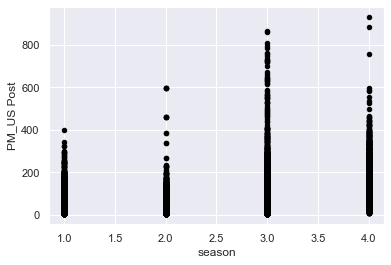

In [69]:
# mozemo videti da i postoji odredjena veza izmedju sezone i pm2.5
# i vidimo da je najveca koncentracija tokom jesenjeg perioda, a zatim u zimskom periodu
# To moze biti posledica ogreva u domacinstvima i rada termoelektrana zbog zbog grejanja gradova...
shenyang.plot.scatter(x='season', y='PM_US Post', c="black")
# shenyang[shenyang['season'] == 1]['PM_US Post'].describe()
# shenyang[shenyang['season'] == 2]['PM_US Post'].describe()
# shenyang[shenyang['season'] == 3]['PM_US Post'].describe()
shenyang[shenyang['season'] == 4]['PM_US Post'].describe()

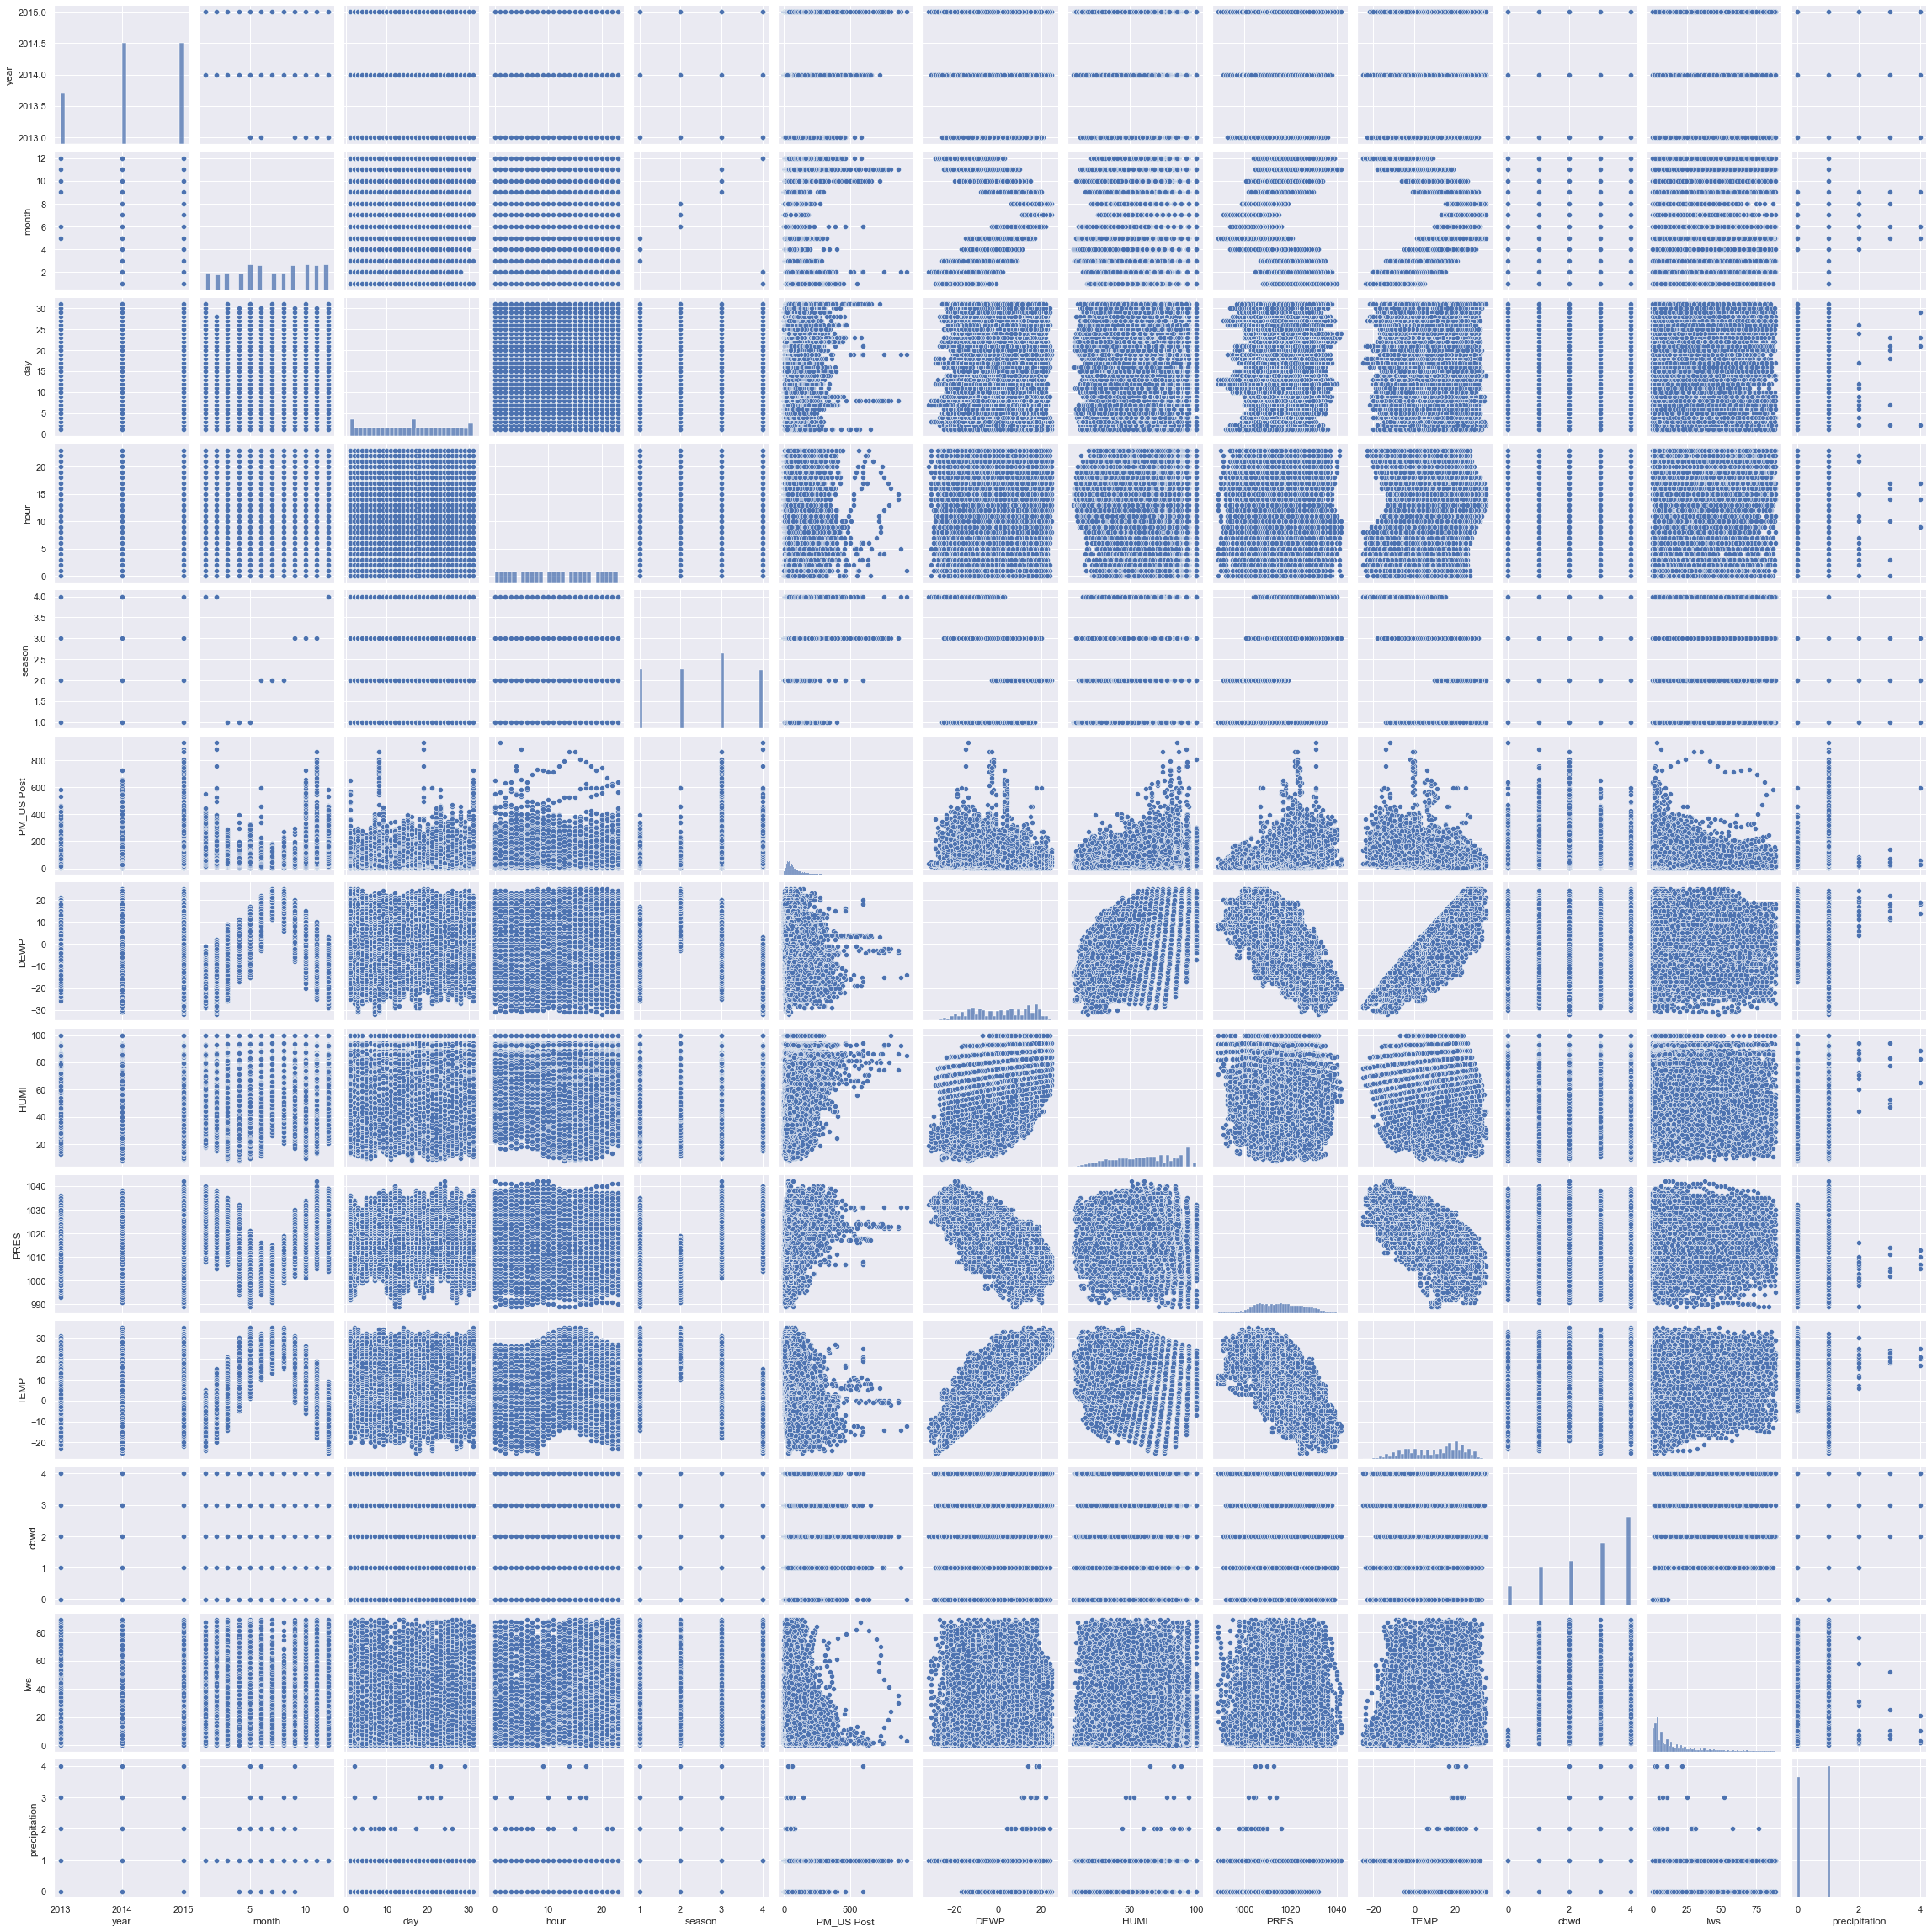

In [71]:
sb.set()
sb.pairplot(shenyang, height = 2.5)
plt.show();

D:\Anaconda\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\Anaconda\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\Anaconda\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings

Text(0, 0.5, 'Probability')

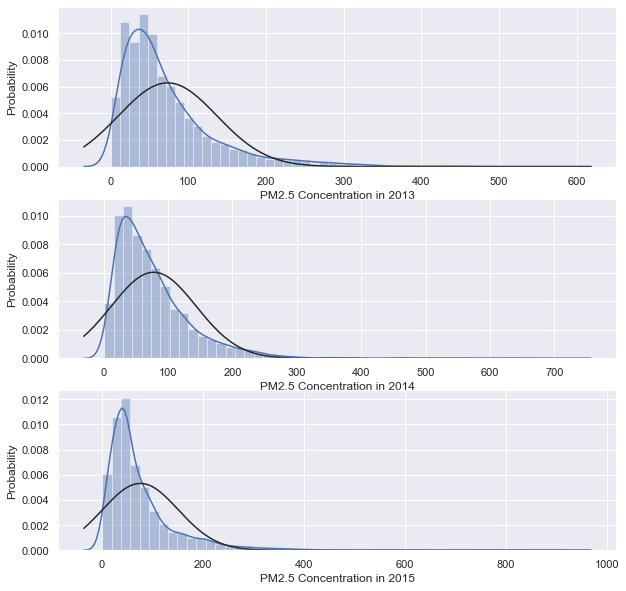

In [47]:
plt.figure(figsize = (10, 10))
plt.subplot(3,1,1)
pm_2013 = shenyang_years.loc['2013','PM_US Post']
sb.distplot(pm_2013, fit=norm)
plt.xlabel('PM2.5 Concentration in 2013')
plt.ylabel('Probability')
plt.subplot(3,1,2)
pm_2014 = shenyang_years.loc['2014','PM_US Post']
sb.distplot(pm_2014, fit=norm)
plt.xlabel('PM2.5 Concentration in 2014')
plt.ylabel('Probability')
plt.subplot(3,1,3)
pm_2015 = shenyang_years.loc['2015','PM_US Post']
sb.distplot(pm_2015, fit=norm)
plt.xlabel('PM2.5 Concentration in 2015')
plt.ylabel('Probability')

In [48]:
print('koef.asimetrije za  PM2.5 u 2013:  %.2f' % skew(shenyang_years.loc['2013','PM_US Post']))
print('koef.spljoštenosti za 2013:  %.2f' % kurtosis(shenyang_years.loc['2013','PM_US Post']))

print('koef.asimetrije za  PM2.5 u 2014:  %.2f' % skew(shenyang_years.loc['2014','PM_US Post']))
print('koef.spljoštenosti za 2014:  %.2f' % kurtosis(shenyang_years.loc['2014','PM_US Post']))

print('koef.asimetrije za  PM2.5 u 2015:  %.2f' % skew(shenyang_years.loc['2015','TEMP']))
print('koef.spljoštenosti za 2015:  %.2f' % kurtosis(shenyang_years.loc['2015','TEMP']))

koef.asimetrije za  PM2.5 u 2013:  2.05
koef.spljoštenosti za 2013:  5.92
koef.asimetrije za  PM2.5 u 2014:  2.82
koef.spljoštenosti za 2014:  14.53
koef.asimetrije za  PM2.5 u 2015:  -0.21
koef.spljoštenosti za 2015:  -1.12


In [49]:
#---------------------------------------------------Regresija--------------------------------------------------------------

In [50]:
# U x smesteni prediktori, dok y varijablu treba predvideti
x=shenyang.drop('PM_US Post', axis=1)
y=shenyang['PM_US Post']
print(x.shape)
print(x.columns)
x.head()

(21911, 12)
Index(['year', 'month', 'day', 'hour', 'season', 'DEWP', 'HUMI', 'PRES',
       'TEMP', 'cbwd', 'Iws', 'precipitation'],
      dtype='object')


,year,month,day,hour,season,DEWP,HUMI,PRES,TEMP,cbwd,Iws,precipitation
29184,2013,5,1,0,1,7.0,87.28,1014.0,9.0,2,38.0,0.0
29185,2013,5,1,1,1,7.0,93.40,1014.0,8.0,2,40.0,0.0
29186,2013,5,1,2,1,6.0,93.35,1014.0,7.0,0,0.0,0.0
29187,2013,5,1,3,1,5.0,93.29,1014.0,6.0,4,1.0,0.0
29188,2013,5,1,4,1,5.0,93.29,1014.0,6.0,0,1.0,0.0


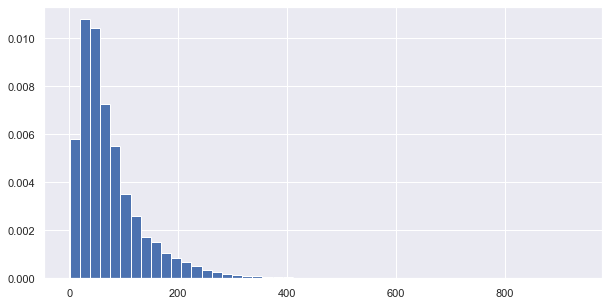

In [51]:
plt.figure(figsize=(10,5))
plt.hist(y, density=True, bins=50)
plt.show()

In [52]:
def model_evaluation(y, y_predicted, N, d):
    mse = mean_squared_error(y_test, y_predicted) # np.mean((y_test-y_predicted)**2)
    mae = mean_absolute_error(y_test, y_predicted) # np.mean(np.abs(y_test-y_predicted))
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_predicted)
    r2_adj = 1-(1-r2)*(N-1)/(N-d-1)

    # printing values
    print('Mean squared error: ', mse)
    print('Mean absolute error: ', mae)
    print('Root mean squared error: ', rmse)
    print('R2 score: ', r2)
    print('R2 adjusted score: ', r2_adj)
    
    # Uporedni prikaz nekoliko pravih i predvidjenih vrednosti
    res=pd.concat([pd.DataFrame(y.values), pd.DataFrame(y_predicted)], axis=1)
    res.columns = ['y', 'y_pred']
    print(res.head(20))

In [53]:
# podela skupa na trening i test podatke
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)

Mean squared error:  4034.5355671904626
Mean absolute error:  42.528727624558464
Root mean squared error:  63.51799404255823
R2 score:  0.20336655506050638
R2 adjusted score:  0.20288144385887874
        y      y_pred
0    83.0   70.458280
1    33.0   98.957769
2    27.0   63.751868
3    98.0   71.089509
4   111.0  113.260250
5   191.0   82.795952
6    86.0   64.308937
7    39.0   76.041753
8     7.0   62.448913
9   128.0  105.108181
10  123.0   44.015195
11   96.0   66.429166
12   46.0   32.308372
13   48.0   40.141580
14   70.0   77.059941
15   26.0   73.559483
16  120.0   76.370755
17   38.0    7.812730
18   19.0   67.550937
19   19.0   83.442156


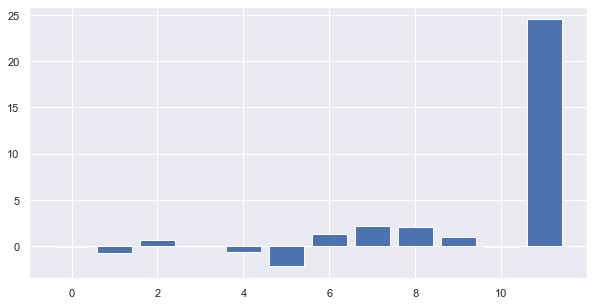

koeficijenti:  [-0.06948775 -0.74140438  0.68721958  0.02597315 -0.67572072 -2.15147456
  1.33158287  2.14414422  2.11091304  0.93082494 -0.14643882 24.56886359]


In [54]:
# Osnovni oblik linearne regresije sa hipotezom y=b0+b1x1+b2x2+...+bnxn
# Inicijalizacija
first_regression_model = LinearRegression(fit_intercept=True)

# Obuka
first_regression_model.fit(x_train, y_train)

# Testiranje
y_predicted = first_regression_model.predict(x_test)

# Evaluacija
model_evaluation(y_test, y_predicted, x_train.shape[0], x_train.shape[1])

# Ilustracija koeficijenata
plt.figure(figsize=(10,5))
plt.bar(range(len(first_regression_model.coef_)),first_regression_model.coef_)
plt.show()
print("koeficijenti: ", first_regression_model.coef_)

In [55]:
# Selekcija obelezja
X = sm.add_constant(x_train)

model = sm.OLS(y_train, X.astype('float')).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             PM_US Post   R-squared:                       0.215
Model:                            OLS   Adj. R-squared:                  0.214
Method:                 Least Squares   F-statistic:                     448.9
Date:                Mon, 29 Nov 2021   Prob (F-statistic):               0.00
Time:                        22:37:29   Log-Likelihood:            -1.0912e+05
No. Observations:               19719   AIC:                         2.183e+05
Df Residuals:                   19706   BIC:                         2.184e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -2077.5357   1205.027     -1.724      0.085   -4439.489     284.418
year             -0.0695      0.598     -0.116      0.907      -1.241       1.102
month            -0.7414      0.148     -5.013      0.000      -1.031      -0.452
day               0.6872      0.050     13.822      0.000       0.590       0.785
hour              0.0260      0.066      0.392      0.695      -0.104       0.156
season           -0.6757      0.573     -1.179      0.239      -1.800       0.448
DEWP             -2.1515      0.294     -7.309      0.000      -2.728      -1.575
HUMI              1.3316      0.083     16.118      0.000       1.170       1.494
PRES              2.1441      0.083     25.836      0.000       1.981       2.307
TEMP              2.1109      0.280      7.548      0.000       1.563       2.659
cbwd              0.9308      0.364      2.559      0.011       0.218       1.644
Iws              -0.1464      0.024     -6.129      0.000      -0.193      -0.100
precipitation    24.5689      1.392     17.654      0.000      21.841      27.297
==============================================================================
Omnibus:                    13389.851   Durbin-Watson:                   2.019
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           355683.682
Skew:                           2.897   Prob(JB):                         0.00
Kurtosis:                      22.983   Cond. No.                     6.24e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.24e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [56]:
# Standardizacija obelezja (svodjenje na sr.vr. 0 i varijansu 1)
scaler = StandardScaler()
scaler.fit(x_train)
x_train_std = scaler.transform(x_train)
x_test_std = scaler.transform(x_test)
x_train_std = pd.DataFrame(x_train_std)
x_test_std = pd.DataFrame(x_test_std)
x_train_std.columns = list(x.columns)
x_test_std.columns = list(x.columns)
x_train_std.head()

,year,month,day,hour,season,DEWP,HUMI,PRES,TEMP,cbwd,Iws,precipitation
0,-0.266833,1.469252,0.485499,-1.518812,1.357656,-1.241122,0.066430,0.728009,-1.442007,-0.500257,-0.713439,0.945877
1,-0.266833,0.589645,0.940061,1.226485,0.437954,0.353908,-0.237145,-0.114469,0.395662,-0.500257,2.055711,-1.032459
2,-1.602286,1.469252,0.712780,-0.507387,1.357656,-1.620891,1.078943,1.886416,-2.131133,-1.270746,0.697260,0.945877
3,-0.266833,-1.462769,0.030936,0.648528,1.357656,-1.165169,-1.176567,1.675797,-0.752881,-1.270746,-0.399951,0.945877
4,1.068620,0.882847,-1.219112,-0.940855,0.437954,0.809631,0.991055,0.412080,0.395662,0.270232,0.070282,0.945877


Mean squared error:  4034.535567190465
Mean absolute error:  42.52872762455848
Root mean squared error:  63.51799404255825
R2 score:  0.20336655506050594
R2 adjusted score:  0.2028814438588783
        y      y_pred
0    83.0   70.458280
1    33.0   98.957769
2    27.0   63.751868
3    98.0   71.089509
4   111.0  113.260250
5   191.0   82.795952
6    86.0   64.308937
7    39.0   76.041753
8     7.0   62.448913
9   128.0  105.108181
10  123.0   44.015195
11   96.0   66.429166
12   46.0   32.308372
13   48.0   40.141580
14   70.0   77.059941
15   26.0   73.559483
16  120.0   76.370755
17   38.0    7.812730
18   19.0   67.550937
19   19.0   83.442156


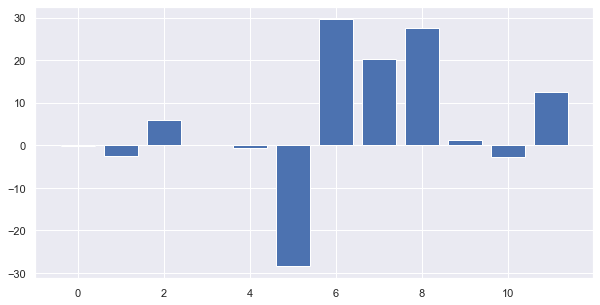

koeficijenti:  [ -0.05203311  -2.52864694   6.04730126   0.17975829  -0.73471666
 -28.32608371  29.69554814  20.3603608   27.56857391   1.20809652
  -2.80275771  12.41895262]


In [57]:
# Ponovo pokrecemo isti test za Linearnu regresiju, samo sto su sada vrednosti koje imaju prevelike tezine, kompresovane
# Standardizacija ne utice na rezultat regresije, ali utice da brze stignemo do resenja
# Osnovni oblik linearne regresije sa hipotezom y=b0+b1x1+b2x2+...+bnxn
# Inicijalizacija
regression_model_std = LinearRegression()

# Obuka modela
regression_model_std.fit(x_train_std, y_train)

# Testiranje
y_predicted = regression_model_std.predict(x_test_std)

# Evaluacija
model_evaluation(y_test, y_predicted, x_train_std.shape[0], x_train_std.shape[1])


# Ilustracija koeficijenata
plt.figure(figsize=(10,5))
plt.bar(range(len(regression_model_std.coef_)),regression_model_std.coef_)
plt.show()
print("koeficijenti: ", regression_model_std.coef_)

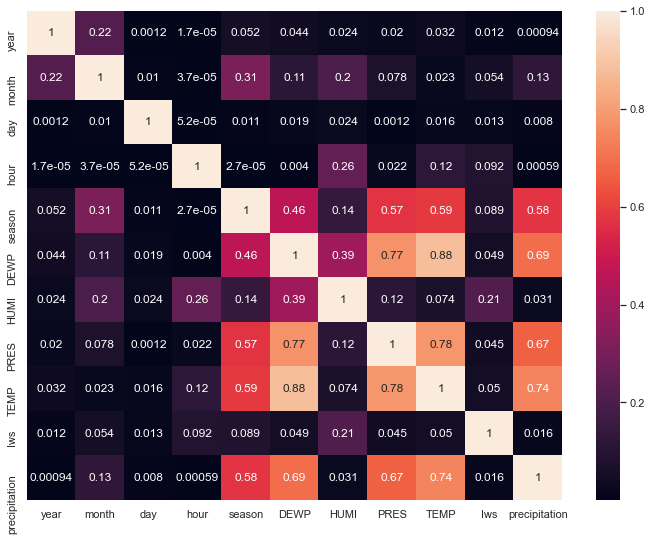

In [58]:
corr = x.corr()
f = plt.figure(figsize=(12, 9))
sb.heatmap(corr.abs(), annot=True);

['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x0 x1', 'x0 x2', 'x0 x3', 'x0 x4', 'x0 x5', 'x0 x6', 'x0 x7', 'x0 x8', 'x0 x9', 'x0 x10', 'x0 x11', 'x1 x2', 'x1 x3', 'x1 x4', 'x1 x5', 'x1 x6', 'x1 x7', 'x1 x8', 'x1 x9', 'x1 x10', 'x1 x11', 'x2 x3', 'x2 x4', 'x2 x5', 'x2 x6', 'x2 x7', 'x2 x8', 'x2 x9', 'x2 x10', 'x2 x11', 'x3 x4', 'x3 x5', 'x3 x6', 'x3 x7', 'x3 x8', 'x3 x9', 'x3 x10', 'x3 x11', 'x4 x5', 'x4 x6', 'x4 x7', 'x4 x8', 'x4 x9', 'x4 x10', 'x4 x11', 'x5 x6', 'x5 x7', 'x5 x8', 'x5 x9', 'x5 x10', 'x5 x11', 'x6 x7', 'x6 x8', 'x6 x9', 'x6 x10', 'x6 x11', 'x7 x8', 'x7 x9', 'x7 x10', 'x7 x11', 'x8 x9', 'x8 x10', 'x8 x11', 'x9 x10', 'x9 x11', 'x10 x11']
Mean squared error:  3523.0337615835124
Mean absolute error:  38.300339944620596
Root mean squared error:  59.35514941084314
R2 score:  0.30436441186641205
R2 adjusted score:  0.3016017043371646
        y      y_pred
0    83.0   67.592404
1    33.0   83.912802
2    27.0   36.796006
3    98.0   71.088914
4   

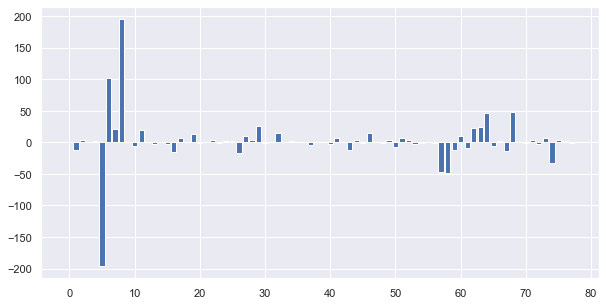

koeficijenti:  [ 8.67497145e-01 -1.15708185e+01  3.58462666e+00  3.67796347e-01
  2.77780946e+00 -1.95883901e+02  1.02102309e+02  2.17207274e+01
  1.95746116e+02  2.36030034e-01 -5.99653261e+00  2.02666037e+01
  7.43021901e-01 -2.43708098e+00  1.20228853e+00 -2.45183509e+00
 -1.47745875e+01  7.19912084e+00  2.90489089e-02  1.35708307e+01
 -1.43987215e+00  1.35567325e+00  3.61023652e+00 -2.79709901e-01
  1.59297550e+00  1.87097494e+00 -1.74158677e+01  1.06771599e+01
  4.48185412e+00  2.51877866e+01 -1.49428394e+00  9.92782301e-01
  1.50081295e+01  1.14597851e-01  1.74817752e+00  9.80758156e-02
  4.50172529e-01 -4.57983303e+00  3.56203145e-01 -1.63611252e-01
 -2.99246277e+00  6.60769591e+00  8.81423159e-01 -1.15177707e+01
  3.52350578e+00 -3.86830672e-01  1.43389765e+01  1.02919653e+00
 -5.77107764e-01  3.67975869e+00 -6.90960024e+00  6.92749256e+00
  4.03822907e+00 -2.32518229e+00 -1.20317587e+00  3.28453203e-02
 -1.76691553e+00 -4.69934058e+01 -4.79140055e+01 -1.20355202e+01
  9.858058

In [59]:
# sledeca hipoteza modela ce uracunati samo obelezja koja su u interakciji
poly = PolynomialFeatures(interaction_only=True, include_bias=False)
x_inter_train = poly.fit_transform(x_train_std)
x_inter_test = poly.transform(x_test_std)

print(poly.get_feature_names())

# Linearna regresija sa hipotezom y=b0+b1x1+b2x2+...+bnxn+c1x1x2+c2x1x3+...

# Inicijalizacija
regression_model_inter = LinearRegression()

# Obuka modela
regression_model_inter.fit(x_inter_train, y_train)

# Testiranje
y_predicted = regression_model_inter.predict(x_inter_test)

# Evaluacija
model_evaluation(y_test, y_predicted, x_inter_train.shape[0], x_inter_train.shape[1])


# Ilustracija koeficijenata
plt.figure(figsize=(10,5))
plt.bar(range(len(regression_model_inter.coef_)),regression_model_inter.coef_)
plt.show()
print("koeficijenti: ", regression_model_inter.coef_)

Mean squared error:  3437.3704190388744
Mean absolute error:  37.46630316376323
Root mean squared error:  58.62909191722889
R2 score:  0.3212789445405877
R2 adjusted score:  0.31816681416605397
        y      y_pred
0    83.0   63.358490
1    33.0   87.782102
2    27.0   31.088992
3    98.0   63.531278
4   111.0  105.464197
5   191.0   67.580661
6    86.0   76.841978
7    39.0   34.369740
8     7.0   51.588279
9   128.0  138.720094
10  123.0   62.856150
11   96.0   91.611207
12   46.0   19.763749
13   48.0   46.840364
14   70.0   72.323187
15   26.0   33.235450
16  120.0  110.656573
17   38.0   53.480298
18   19.0   41.274354
19   19.0   53.921674


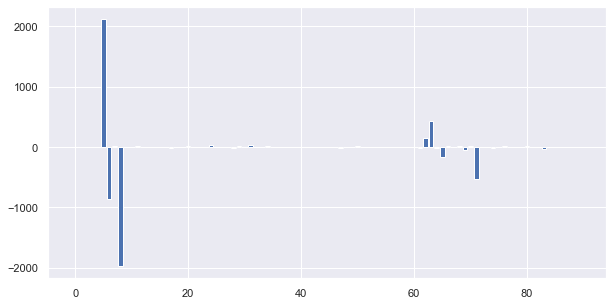

koeficijenti:  [-9.41986729e-01 -7.11363335e+00  3.21023404e+00  1.47273779e-01
 -4.59822554e+00  2.12143161e+03 -8.63697030e+02  2.13229485e+01
 -1.96970063e+03  4.42900477e-01 -8.10090624e+00  1.18338340e+01
 -8.44160837e+00 -2.55560579e+00 -2.04506366e+00  1.10711112e+00
 -7.40862616e-01 -1.51005828e+01  6.40270499e+00 -7.38872278e-01
  1.30358081e+01 -1.54479454e+00  1.42731130e+00  4.52252691e+00
  2.46544631e+01  1.02485198e+00  1.81246514e+00 -1.62870115e+00
 -1.90723794e+01  1.28418386e+01  3.68111776e+00  2.55125360e+01
 -1.26972442e+00  8.09247303e-01  2.08410367e+01 -2.51854884e-01
  9.35340335e-03  1.91496266e+00 -9.40810541e-01  9.90822412e-01
 -4.19946956e+00  2.44476213e+00 -9.33631964e-02 -2.65544560e+00
  6.82287836e+00 -1.52135446e+00  7.79802611e-01 -8.71350529e+00
  2.15818662e+00 -4.78817644e-01  1.19021752e+01  8.90792574e-01
 -4.88956797e-01  3.97410443e+00 -3.28960013e+00 -7.26215232e+00
  3.73224793e+00  3.42217412e+00 -2.36781945e+00 -1.78668766e+00
  6.450553

In [60]:
# ova hipoteza obuhvata i drugi stepen obelezja
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
x_inter_train = poly.fit_transform(x_train_std)
x_inter_test = poly.transform(x_test_std)

# Linearna regresija sa hipotezom y=b0+b1x1+b2x2+...+bnxn+c1x1x2+c2x1x3+...+d1x1^2+d2x2^2+...+dnxn^2

# Inicijalizacija
regression_model_degree = LinearRegression()

# Obuka modela
regression_model_degree.fit(x_inter_train, y_train)

# Testiranje
y_predicted = regression_model_degree.predict(x_inter_test)

# Evaluacija
model_evaluation(y_test, y_predicted, x_inter_train.shape[0], x_inter_train.shape[1])

# Ilustracija koeficijenata
plt.figure(figsize=(10,5))
plt.bar(range(len(regression_model_degree.coef_)),regression_model_degree.coef_)
plt.show()
print("koeficijenti: ", regression_model_degree.coef_)

Mean squared error:  3451.560173455014
Mean absolute error:  37.599687028136856
Root mean squared error:  58.7499801996138
R2 score:  0.31847712689513163
R2 adjusted score:  0.3153521493844612
        y      y_pred
0    83.0   62.388431
1    33.0   88.937762
2    27.0   32.500067
3    98.0   64.797678
4   111.0  104.838196
5   191.0   66.284800
6    86.0   74.861226
7    39.0   36.021284
8     7.0   46.380617
9   128.0  141.825056
10  123.0   65.509945
11   96.0   91.737556
12   46.0   24.819284
13   48.0   45.744384
14   70.0   68.532565
15   26.0   33.462325
16  120.0  110.250729
17   38.0   51.669096
18   19.0   43.880605
19   19.0   51.311631


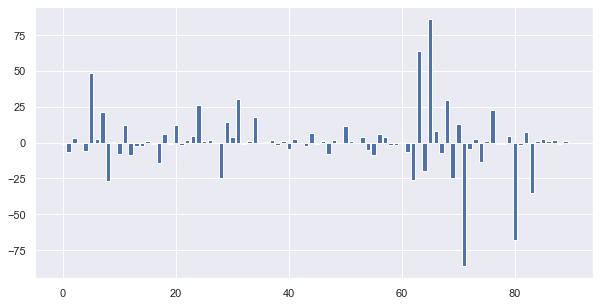

koeficijenti:  [-9.08479874e-01 -6.56545780e+00  3.36530468e+00  1.70173848e-03
 -6.07788656e+00  4.81783394e+01  2.48821046e+00  2.13909102e+01
 -2.67590625e+01  4.47709261e-01 -8.28344550e+00  1.18928563e+01
 -8.44457359e+00 -2.57984663e+00 -2.11804538e+00  1.06907556e+00
 -9.72822884e-01 -1.40787016e+01  6.14435805e+00 -7.30162102e-01
  1.21459738e+01 -1.51647289e+00  1.42019858e+00  4.57272077e+00
  2.59653617e+01  1.08383905e+00  1.87263512e+00 -3.00244392e-01
 -2.49741167e+01  1.41308444e+01  3.78389483e+00  3.01041146e+01
 -1.25501926e+00  8.49983869e-01  1.78361369e+01 -3.26677744e-01
  1.09808989e-02  2.05203508e+00 -1.51092071e+00  1.09482503e+00
 -4.35882509e+00  2.30596873e+00 -1.43563443e-02 -2.69053797e+00
  6.47478321e+00 -1.37314233e+00  7.20042590e-01 -8.19730462e+00
  2.03477352e+00 -3.79011351e-01  1.15320109e+01  8.93201703e-01
 -5.78883579e-01  3.82765399e+00 -5.45676289e+00 -8.41063714e+00
  5.96354739e+00  3.73064521e+00 -1.59955984e+00 -1.76020370e+00
  5.873404

In [61]:
#Ridge regresija
# Inicijalizacija
ridge_model = Ridge(alpha=1)

# Obuka modela
ridge_model.fit(x_inter_train, y_train)

# Testiranje
y_predicted = ridge_model.predict(x_inter_test)

# Evaluacija
model_evaluation(y_test, y_predicted, x_inter_train.shape[0], x_inter_train.shape[1])


# Ilustracija koeficijenata
plt.figure(figsize=(10,5))
plt.bar(range(len(ridge_model.coef_)),ridge_model.coef_)
plt.show()
print("koeficijenti: ", ridge_model.coef_)

Mean squared error:  3471.958556517027
Mean absolute error:  37.54233523006988
Root mean squared error:  58.9233277787077
R2 score:  0.3144493933681217
R2 adjusted score:  0.3113059475459866
        y      y_pred
0    83.0   58.953815
1    33.0   83.846283
2    27.0   36.998337
3    98.0   60.778677
4   111.0  100.651217
5   191.0   64.607302
6    86.0   69.841852
7    39.0   41.379955
8     7.0   47.040553
9   128.0  135.660151
10  123.0   66.097070
11   96.0   87.326649
12   46.0   28.752858
13   48.0   45.023887
14   70.0   76.561157
15   26.0   37.538605
16  120.0  111.541890
17   38.0   46.793175
18   19.0   45.770784
19   19.0   48.531349


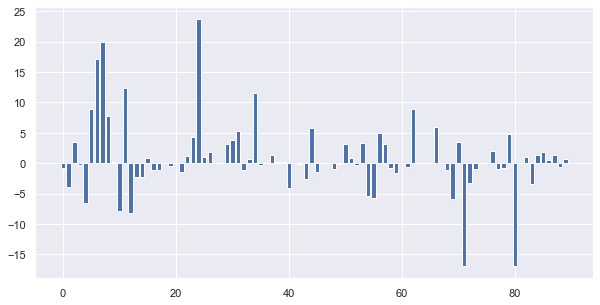

koeficijenti:  [ -0.82257537  -3.90463268   3.5383452   -0.20822935  -6.48634188
   8.98697068  17.15845837  19.94127138   7.78041069   0.18948253
  -7.79414887  12.29761909  -8.10468649  -2.28601555  -2.18703836
   0.89969561  -1.07375533  -1.04919733  -0.          -0.52171554
   0.          -1.48075357   1.24887083   4.27680445  23.73650137
   1.03441442   1.84991688   0.           0.           3.21663968
   3.74210048   5.33198672  -1.18224588   0.66892577  11.62460604
  -0.33345081  -0.           1.39700631   0.20351642   0.28642616
  -4.09036567   0.          -0.06146796  -2.51398234   5.78892349
  -1.37912742   0.          -0.          -0.86590161  -0.12227674
   3.23363385   0.85702236  -0.33810694   3.3824936   -5.41983245
  -5.78354689   4.98462835   3.14554609  -0.69912397  -1.65450161
   0.          -0.68716647   8.98462799   0.          -0.
  -0.           6.003923    -0.          -1.12569109  -5.82641865
   3.54925729 -16.88225966  -3.31388314  -0.89538438  -0.
   0.      

In [62]:
# Lasso regresija
# Model initialization
lasso_model = Lasso(alpha=0.1)

# Fit the data(train the model)
lasso_model.fit(x_inter_train, y_train)

# Predict
y_predicted = lasso_model.predict(x_inter_test)

# Evaluation
model_evaluation(y_test, y_predicted, x_inter_train.shape[0], x_inter_train.shape[1])


#ilustracija koeficijenata
plt.figure(figsize=(10,5))
plt.bar(range(len(lasso_model.coef_)),lasso_model.coef_)
plt.show()
print("koeficijenti: ", lasso_model.coef_)

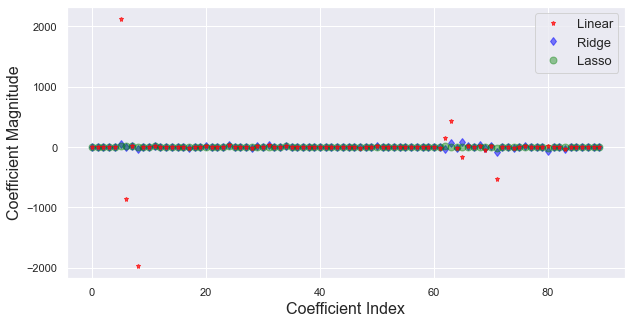

In [63]:
plt.figure(figsize=(10,5))
plt.plot(regression_model_degree.coef_,alpha=0.7,linestyle='none',marker='*',markersize=5,color='red',label=r'Linear',zorder=7) # zorder for ordering the markers
plt.plot(ridge_model.coef_,alpha=0.5,linestyle='none',marker='d',markersize=6,color='blue',label=r'Ridge') # alpha here is for transparency
plt.plot(lasso_model.coef_,alpha=0.4,linestyle='none',marker='o',markersize=7,color='green',label='Lasso')
plt.xlabel('Coefficient Index',fontsize=16)
plt.ylabel('Coefficient Magnitude',fontsize=16)
plt.legend(fontsize=13,loc='best')
plt.show()